In [ ]:
# %%

import torchsummary as summary
import librosa
import matplotlib.pyplot as plt
import soundfile as sf
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim.adamw import AdamW
from data.config import *
from data.utils import save_checkpoint, load_checkpoint
# from data.dataset import MixtureDataset, AudioMixtureDataset
# from data.dataset import AudioDataset
from data.dataset import PreComputedMixtureDataset
from tqdm import tqdm
from torchlibrosa.stft import STFT, ISTFT, magphase
from torch.utils.data import DataLoader, SubsetRandomSampler
from sklearn.model_selection import train_test_split
from model.base import Base

torch.backends.cudnn.benchmark = True
torch.backends.cudnn.enabled = True

# mp.set_start_method('spawn', force=True)

# os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
# os.environ['TORCH_USE_CUDA_DSA'] = '1'


class ResidualBlock(nn.Module):
    def __init__(self, in_c, out_c, stride=1):
        super(ResidualBlock, self).__init__()

        self.residual_block = nn.Sequential(
            nn.BatchNorm2d(in_c),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(in_c, out_c,
                      kernel_size=3, stride=stride, padding=1),
            nn.BatchNorm2d(out_c),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(out_c, out_c,
                      kernel_size=3, stride=1, padding=1),
        )

        """ Shortcut Connection """
        self.shortcut = nn.Conv2d(
            in_c, out_c, kernel_size=1, stride=stride, padding=0)

    def forward(self, inputs):
        x = self.residual_block(inputs)
        s = self.shortcut(inputs)

        skip = x + s
        return skip


class DecoderBlock(nn.Module):
    def __init__(self, in_c, out_c):
        super(DecoderBlock, self).__init__()
        self.upsampling = nn.ConvTranspose2d(
            in_c, out_c, kernel_size=2, stride=2, padding=0, dilation=1)
        self.residual_block = ResidualBlock(
            out_c * 2, out_c)
        # self.upsampling = nn.Upsample(
        #     scale_factor=2, mode='bilinear', align_corners=True)
        # self.residual_block = ResidualBlock(
        #     in_c + out_c, out_c)

    def forward(self, x, skip):
        # Upsample
        x = self.upsampling(x)
        # Ensure x and skip have the same spatial dimensions
        if x.shape[2:] != skip.shape[2:]:
            x = F.interpolate(
                x, size=(skip.shape[2], skip.shape[3]), mode='bilinear', align_corners=True)

        # Concatenate
        x = torch.cat([x, skip], dim=1)

        # Residual block
        x = self.residual_block(x)

        return x


class ResUNet(nn.Module):
    def __init__(self, in_c, out_c):
        super(ResUNet, self).__init__()

        """ Encoder 1 """
        self.encoder_block1 = nn.Sequential(
            nn.Conv2d(in_c, out_c,
                      kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_c),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(out_c, out_c,
                      kernel_size=3, stride=1, padding=1),
        )

        """ Shortcut Connection """
        self.shortcut = nn.Conv2d(in_c, out_c, kernel_size=1, padding=0)

        """ Encoder 2 and 3"""
        self.encoder_block2 = ResidualBlock(
            out_c, out_c * 2, stride=2)
        self.encoder_block3 = ResidualBlock(
            out_c * 2, out_c * 4, stride=2)

        """ Bridge """
        self.bridge = ResidualBlock(
            out_c * 4, out_c * 8, stride=2)

        """ Decoder """
        self.decoder_block1 = DecoderBlock(out_c * 8, out_c * 4)
        self.decoder_block2 = DecoderBlock(out_c * 4, out_c * 2)
        self.decoder_block3 = DecoderBlock(out_c * 2, out_c)

        """ Output """
        self.output = nn.Sequential(
            nn.Conv2d(out_c, 3, kernel_size=1, padding=0),
        )

        # self.classifier = nn.Sequential(
        #     nn.MaxPool2d(kernel_size=2, stride=2),
        #     nn.ReLU(),
        #     nn.Conv2d(out_c*4, out_c*2, kernel_size=3, padding=1),
        #     nn.MaxPool2d(kernel_size=2, stride=2),
        #     nn.ReLU(),

        #     # Linear
        #     nn.Flatten(),
        #     nn.Linear(out_c*2 * 8 * 30, out_c*2),
        #     nn.ReLU(),
        #     nn.Dropout(0.3),
        #     nn.Linear(out_c*2, out_c),
        #     nn.ReLU(),
        #     nn.Dropout(0.3),
        #     nn.Linear(out_c, 8)
        # )

        self.classifier = nn.Sequential(
            nn.MaxPool2d(4, 4),
            nn.ReLU(inplace=True),

            nn.Conv2d(out_c*4, out_c*2, kernel_size=3, padding=1),
            nn.MaxPool2d(2, 2),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),

            nn.Flatten(),
            # nn.Linear(out_c*4 * 16 * 61, 128),
            # nn.Linear(out_c*4 * 8 * 30, 128),
            nn.Linear(out_c*2 * 4 * 15, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, 8)
        )

    def forward(self, x):

        x = x.unsqueeze(1)

        """ Encoder 1 """
        encoder1 = self.encoder_block1(x)
        s = self.shortcut(x)
        skip1 = encoder1 + s

        """ Encoder 2 and 3 """
        skip2 = self.encoder_block2(skip1)
        skip3 = self.encoder_block3(skip2)

        """ Bridge """
        bridge = self.bridge(skip3)

        """ Decoder """
        decoder1 = self.decoder_block1(bridge, skip3)
        decoder2 = self.decoder_block2(decoder1, skip2)
        decoder3 = self.decoder_block3(decoder2, skip1)

        """ Output """
        output = self.output(decoder3)

        output_masks_dict = {
            'mag_mask': torch.sigmoid(output[:, 0, :, :]),
            'real_mask': torch.tanh(output[:, 1, :, :]),
            'imag_mask': torch.tanh(output[:, 2, :, :])
        }

        class_output = self.classifier(skip3)
        # return output, class_output

        return output_masks_dict, class_output


class ResUNetv2(nn.Module, Base):
    def __init__(self, in_c, out_c):
        super(ResUNetv2, self).__init__()

        window_size = 256
        hop_size = 64
        center = True
        pad_mode = "reflect"
        window = "hann"

        self.output_channels = 1
        # self.target_sources_num = 1
        self.K = 3

        # downsample ratio
        self.time_downsample_ratio = 2**3  # number of encoder layers

        self.stft = STFT(
            n_fft=window_size,
            hop_length=hop_size,
            win_length=window_size,
            window=window,
            center=center,
            pad_mode=pad_mode,
            freeze_parameters=True,
        )

        self.istft = ISTFT(
            n_fft=window_size,
            hop_length=hop_size,
            win_length=window_size,
            window=window,
            center=center,
            pad_mode=pad_mode,
            freeze_parameters=True,
        )

        """ Encoder 1 """
        self.encoder_block1 = nn.Sequential(
            nn.Conv2d(in_c, out_c,
                      kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_c),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(out_c, out_c,
                      kernel_size=3, stride=1, padding=1),
        )

        """ Shortcut Connection """
        self.shortcut = nn.Conv2d(in_c, out_c, kernel_size=1, padding=0)
        # self.shortcut = nn.Conv2d(in_c, out_c, kernel_size=1, padding="same"),

        """ Encoder 2 and 3"""
        self.encoder_block2 = ResidualBlock(out_c, out_c * 2, stride=2)
        self.encoder_block3 = ResidualBlock(out_c * 2, out_c * 4, stride=2)

        """ Bridge """
        self.bridge = ResidualBlock(
            out_c * 4, out_c * 8, stride=2)

        """ Decoder """
        self.decoder_block1 = DecoderBlock(out_c * 8, out_c * 4)
        self.decoder_block2 = DecoderBlock(out_c * 4, out_c * 2)
        self.decoder_block3 = DecoderBlock(out_c * 2, out_c)

        """ Output """
        # self.last_layer = nn.Sequential(
        #     # nn.Conv2d(out_c, 1, kernel_size=1, padding='same'),
        #     nn.Conv2d(out_c, 1, kernel_size=1, padding=0),
        # )

        self.after_conv = nn.Conv2d(
            in_channels=out_c,
            out_channels=self.output_channels * self.K,
            kernel_size=(1, 1),
            stride=(1, 1),
            padding=(0, 0),
            bias=True,
        )

    def feature_maps_to_wav(
        self,
        input_tensor: torch.Tensor,
        sp: torch.Tensor,
        sin_in: torch.Tensor,
        cos_in: torch.Tensor,
        audio_length: int,
    ) -> torch.Tensor:
        r"""Convert feature maps to waveform.

        Args:
            input_tensor: (batch_size, target_sources_num * output_channels * self.K, time_steps, freq_bins)
            sp: (batch_size, input_channels, time_steps, freq_bins)
            sin_in: (batch_size, input_channels, time_steps, freq_bins)
            cos_in: (batch_size, input_channels, time_steps, freq_bins)

            (There is input_channels == output_channels for the source separation task.)

        Outputs:
            waveform: (batch_size, target_sources_num * output_channels, segment_samples)
        """
        batch_size, _, time_steps, freq_bins = input_tensor.shape

        x = input_tensor.reshape(
            batch_size,
            # self.target_sources_num,
            self.output_channels,
            self.K,
            time_steps,
            freq_bins,
        )
        # x: (batch_size, target_sources_num, output_channels, self.K, time_steps, freq_bins)

        # mask_mag = torch.sigmoid(x[:, :, :, 0, :, :])
        # _mask_real = torch.tanh(x[:, :, :, 1, :, :])
        # _mask_imag = torch.tanh(x[:, :, :, 2, :, :])

        mask_mag = torch.sigmoid(x[:, :, 0, :, :])
        _mask_real = torch.tanh(x[:, :, 1, :, :])
        _mask_imag = torch.tanh(x[:, :, 2, :, :])
        # print(mask_mag.shape)
        # linear_mag = torch.tanh(x[:, :, :, 3, :, :])
        _, mask_cos, mask_sin = magphase(_mask_real, _mask_imag)
        # print(mask_mag.shape)
        # mask_cos, mask_sin: (batch_size, target_sources_num, output_channels, time_steps, freq_bins)

        # Y = |Y|cos∠Y + j|Y|sin∠Y
        #   = |Y|cos(∠X + ∠M) + j|Y|sin(∠X + ∠M)
        #   = |Y|(cos∠X cos∠M - sin∠X sin∠M) + j|Y|(sin∠X cos∠M + cos∠X sin∠M)
        out_cos = (
            cos_in[:, :, :, :] * mask_cos -
            sin_in[:, :, :, :] * mask_sin
        )
        out_sin = (
            sin_in[:, :, :, :] * mask_cos +
            cos_in[:, :, :, :] * mask_sin
        )
        # print(out_cos.shape)
        # out_cos: (batch_size, target_sources_num, output_channels, time_steps, freq_bins)
        # out_sin: (batch_size, target_sources_num, output_channels, time_steps, freq_bins)

        # Calculate |Y|.
        out_mag = F.relu_(sp[:, :, :, :] * mask_mag)
        # print(out_mag.shape)
        # out_mag: (batch_size, target_sources_num, output_channels, time_steps, freq_bins)

        # Calculate Y_{real} and Y_{imag} for ISTFT.
        out_real = out_mag * out_cos
        out_imag = out_mag * out_sin
        # out_real, out_imag: (batch_size, target_sources_num, output_channels, time_steps, freq_bins)
        # print(out_real.shape)
        # Reformat shape to (N, 1, time_steps, freq_bins) for ISTFT where
        # N = batch_size * target_sources_num * output_channels
        # shape = (batch_size * self.target_sources_num *
        #  self.output_channels, 1, time_steps, freq_bins)

        shape = (batch_size * self.output_channels, 1, time_steps, freq_bins)
        shape = (batch_size, 1, time_steps, freq_bins)
        # print(shape)

        out_real = out_real.reshape(shape)
        out_imag = out_imag.reshape(shape)
        # print(out_real.shape)
        # ISTFT.
        x = self.istft(out_real, out_imag, audio_length)
        # (batch_size * target_sources_num * output_channels, segments_num)

        # Reshape.
        # waveform = x.reshape(batch_size, self.target_sources_num * self.output_channels, audio_length)
        waveform = x.reshape(batch_size, self.output_channels, audio_length)
        # (batch_size, target_sources_num * output_channels, segments_num)
        return waveform

    def forward(self, mixtures):
        """
        Args:
            input: (batch_size, segment_samples)

        Outputs:
            output_dict: {
            'wav': (batch_size, segment_samples),
            'sp': (batch_size, channels_num, time_steps, freq_bins)}
        """
        mag, cos_in, sin_in = self.wav_to_spectrogram_phase(mixtures)
        x = mag
        # Pad spectrogram to be evenly divided by downsample ratio.
        origin_len = x.shape[2]
        pad_len = (
            int(np.ceil(x.shape[2] / self.time_downsample_ratio)
                ) * self.time_downsample_ratio
            - origin_len
        )
        x = F.pad(x, pad=(0, 0, 0, pad_len))

        """(batch_size, channels, padded_time_steps, freq_bins)"""
        # Let frequency bins be evenly divided by 2, e.g., 489 -> 488.
        x = x[..., 0: x.shape[-1] - 1]  # (bs, channels, T, F)
        # UNet
        """ Encoder 1 """
        encoder1 = self.encoder_block1(x)
        s = self.shortcut(x)
        skip1 = encoder1 + s

        """ Encoder 2 and 3 """
        skip2 = self.encoder_block2(skip1)
        skip3 = self.encoder_block3(skip2)

        """ Bridge """
        bridge = self.bridge(skip3)

        """ Decoder """
        decoder1 = self.decoder_block1(bridge, skip3)
        decoder2 = self.decoder_block2(decoder1, skip2)
        decoder3 = self.decoder_block3(decoder2, skip1)

        """ Output """
        # output = self.last_layer(decoder3)

        x = self.after_conv(decoder3)

        # (batch_size, target_sources_num * output_channels * self.K, T, F')

        # Recover shape
        x = F.pad(x, pad=(0, 1))
        x = x[:, :, 0:origin_len, :]

        audio_length = mixtures.shape[2]
        # Recover each subband spectrograms to subband waveforms. Then synthesis
        # the subband waveforms to a waveform.
        separated_audio = self.feature_maps_to_wav(
            input_tensor=x,
            # input_tensor: (batch_size, target_sources_num * output_channels * self.K, T, F')
            sp=mag,
            # sp: (batch_size, input_channels, T, F')
            sin_in=sin_in,
            # sin_in: (batch_size, input_channels, T, F')
            cos_in=cos_in,
            # cos_in: (batch_size, input_channels, T, F')
            audio_length=audio_length,
        )
        # （batch_size, target_sources_num * output_channels, subbands_num, segment_samples)

        output_dict = {'waveform': separated_audio}

        return output_dict

In [ ]:
# %%

# Load metadata
metadata = pd.read_csv(os.path.join(
    DATASET_MIX_AUDIO_PATH, "metadata.csv"))

dataset = PreComputedMixtureDataset(metadata_file=metadata)

# Group the metadata by percussion file
grouped_metadata = metadata.groupby('percussion_file')

# Get all unique percussion files
unique_perc_files = metadata['percussion_file'].unique()

# Split based on percussion files, not individual mixtures
train_perc_files, test_perc_files = train_test_split(unique_perc_files, test_size=0.2, random_state=42)
train_perc_files, val_perc_files = train_test_split(train_perc_files, test_size=0.25, random_state=42)  # 0.25 of the remaining for validation

# Create train, validation, and test datasets by filtering the metadata
train_metadata = metadata[metadata['percussion_file'].isin(train_perc_files)]
val_metadata = metadata[metadata['percussion_file'].isin(val_perc_files)]
test_metadata = metadata[metadata['percussion_file'].isin(test_perc_files)]

# Save the indices (if needed)
train_indices = train_metadata.index.tolist()
val_indices = val_metadata.index.tolist()
test_indices = test_metadata.index.tolist()

np.save('train_indices_new_last.npy', train_indices)
np.save('val_indices_new_last.npy', val_indices)
np.save('test_indices_new_last.npy', test_indices)

# Use these new indices for your DataLoader
train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)
test_sampler = SubsetRandomSampler(test_indices)

train_loader = DataLoader(dataset, sampler=train_sampler, batch_size=25)
val_loader = DataLoader(dataset, sampler=val_sampler, batch_size=25)
test_loader = DataLoader(dataset, sampler=test_sampler, batch_size=25)

In [ ]:
#%%

# based on indices see if files of percussion (by looking at the names) are repeted in the train, val and test sets

train_files = metadata.iloc[train_indices]
val_files = metadata.iloc[val_indices]
test_files = metadata.iloc[test_indices]

train_perc_files = train_files['percussion_file']
val_perc_files = val_files['percussion_file']
test_perc_files = test_files['percussion_file']

train_perc_files = train_perc_files.apply(lambda x: x.split('/')[-1])
val_perc_files = val_perc_files.apply(lambda x: x.split('/')[-1])
test_perc_files = test_perc_files.apply(lambda x: x.split('/')[-1])

train_perc_files = train_perc_files.to_list()
val_perc_files = val_perc_files.to_list()
test_perc_files = test_perc_files.to_list()

print(len(train_perc_files))
print(len(val_perc_files))
print(len(test_perc_files))

print(len(set(train_perc_files)))
print(len(set(val_perc_files)))
print(len(set(test_perc_files)))

print(len(set(train_perc_files).intersection(set(val_perc_files))))
print(len(set(train_perc_files).intersection(set(test_perc_files))))
print(len(set(val_perc_files).intersection(set(test_perc_files))))

# all the files repeat themselves IT'S BAD because it means the model will have seen all the percussion file

4392
1482
1484
231
78
78
0
0
0


C:\Users\jejep\Desktop\STAGE\data\mixture_audio\mixture_279_noise_dog_bark_children_playing_k_0.70.wav
C:\Users\jejep\Desktop\STAGE\data\mixture_audio\noise_279_noise_dog_bark_children_playing_k_0.70.wav


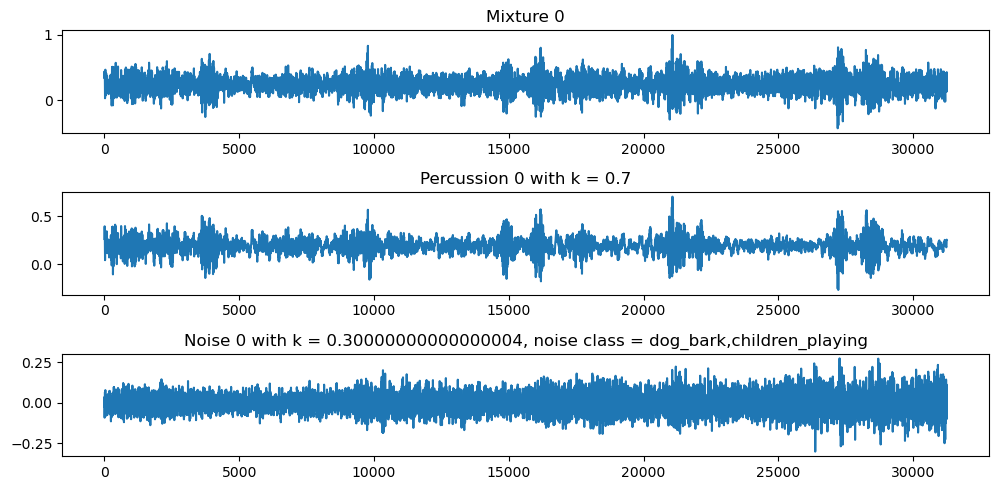

C:\Users\jejep\Desktop\STAGE\data\mixture_audio\mixture_54_noise_air_conditioner_k_0.80.wav
C:\Users\jejep\Desktop\STAGE\data\mixture_audio\noise_54_noise_air_conditioner_k_0.80.wav


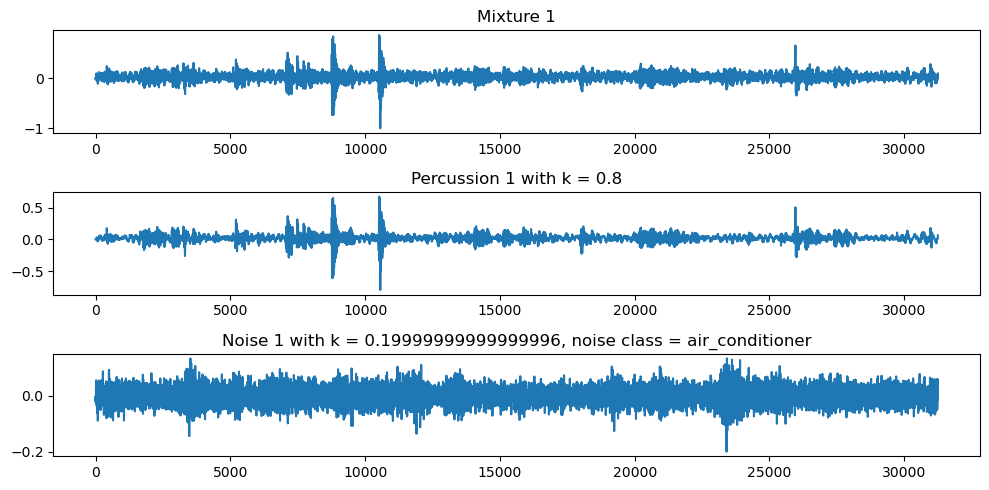

C:\Users\jejep\Desktop\STAGE\data\mixture_audio\mixture_141_noise_air_conditioner_air_conditioner_k_0.50.wav
C:\Users\jejep\Desktop\STAGE\data\mixture_audio\noise_141_noise_air_conditioner_air_conditioner_k_0.50.wav


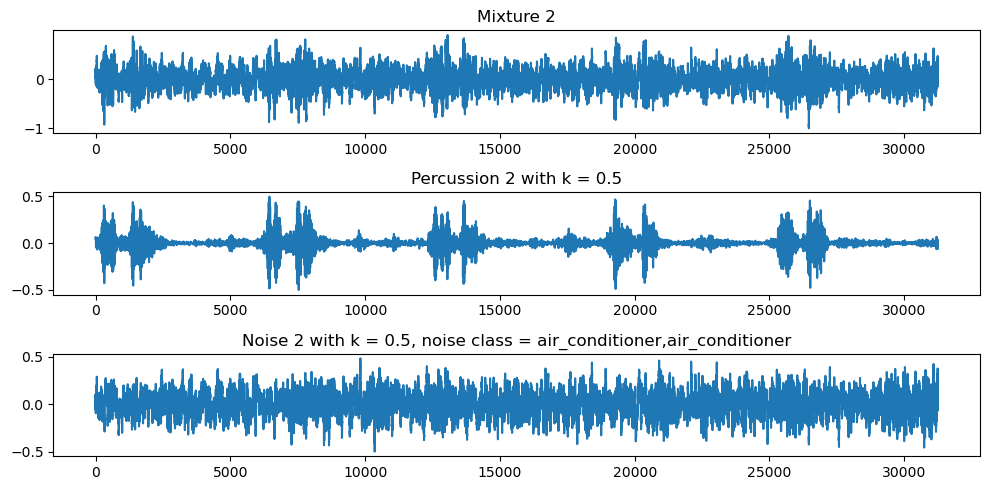

C:\Users\jejep\Desktop\STAGE\data\mixture_audio\mixture_318_noise_engine_idling_engine_idling_k_0.70.wav
C:\Users\jejep\Desktop\STAGE\data\mixture_audio\noise_318_noise_engine_idling_engine_idling_k_0.70.wav


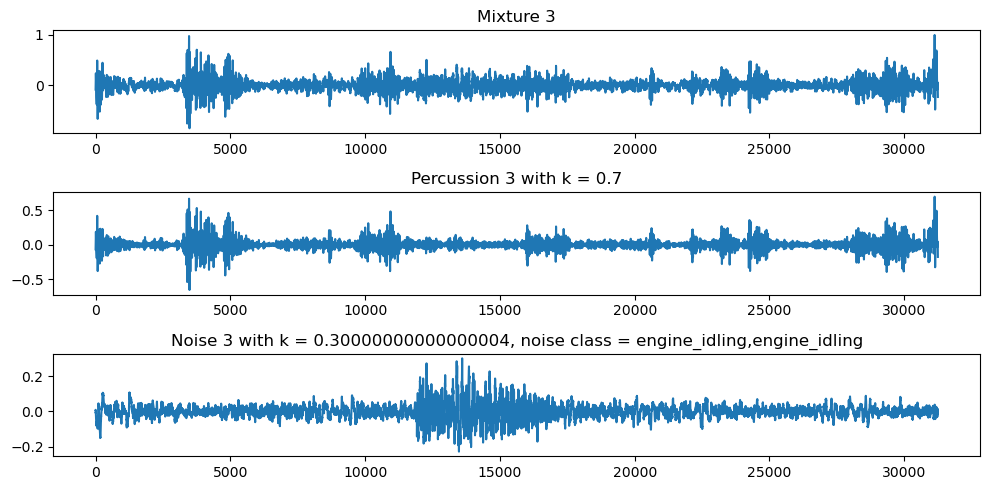

C:\Users\jejep\Desktop\STAGE\data\mixture_audio\mixture_277_noise_children_playing_k_0.80.wav
C:\Users\jejep\Desktop\STAGE\data\mixture_audio\noise_277_noise_children_playing_k_0.80.wav


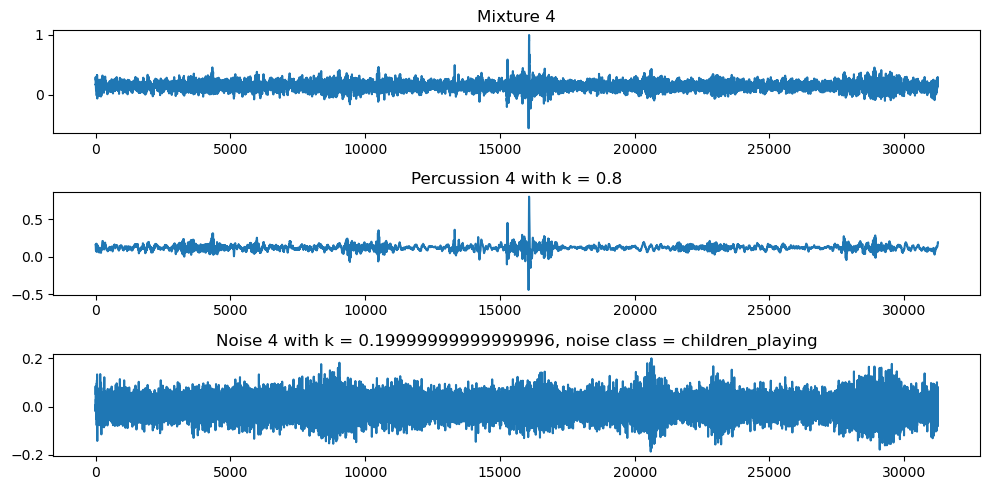

In [ ]:
#%%

data = next(iter(train_loader))

for i in range(5):
    plt.figure(figsize=(10, 5))
    plt.subplot(3, 1, 1)
    plt.plot(data['mixture_audio'][i,0].numpy())
    plt.title(f'Mixture {i}')
    plt.subplot(3, 1, 2)
    plt.plot(data['percussion_audio'][i,0].numpy())
    plt.title(f'Percussion {i} with k = {data["k"][i]}')
    plt.subplot(3, 1, 3)
    plt.plot(data['noise_audio'][i,0].numpy())
    plt.title(f'Noise {i} with k = {1-data["k"][i]}, noise class = {data["noise_classes"][i]}')
    
    # print path of mix and noise
    print(os.path.join(DATASET_MIX_AUDIO_PATH, data['mix_name'][i]))
    print(os.path.join(DATASET_MIX_AUDIO_PATH, data['noise_file'][i]))
    
    
    plt.tight_layout()
    plt.show()

In [ ]:
# %%

# Define the model, optimizer and loss function
model = ResUNetv2(in_c=1, out_c=32).to("cuda")
optimizer = AdamW(model.parameters(), lr=0.001, amsgrad=True, fused=True)

criterion = nn.MSELoss()
device = "cuda"

In [ ]:
#%%

# def calculate_snr(true_percussion, predicted_percussion):
#     # Assuming true_percussion and predicted_percussion are tensors of the same shape
#     noise = true_percussion - predicted_percussion
#     sdr = 10 * torch.log10(torch.sum(true_percussion ** 2) / torch.sum(noise ** 2))
    # return sdr.item()

def calculate_si_sdr(true_percussion, predicted_percussion):
    # Rescale predicted to match the scale of true percussive audio
    alpha = torch.sum(true_percussion * predicted_percussion) / torch.sum(predicted_percussion ** 2)
    true_scaled = alpha * predicted_percussion
    noise = true_percussion - true_scaled
    si_sdr = 10 * torch.log10(torch.sum(true_scaled ** 2) / torch.sum(noise ** 2))
    return si_sdr

In [ ]:
# %%

# Train the model

train_losses = []
val_losses = []
best_val_loss = np.inf
patience = 5
num_epochs = 30

start_epoch = 0

for epoch in range(start_epoch, num_epochs):
    model.train()
    train_loss = 0
    train_bar = tqdm(train_loader, desc=f"Epoch {
                     epoch + 1}/{num_epochs} Training Loss: {train_loss:.4f}", colour='green')
    for i, batch in enumerate(train_bar):
        # Zero the parameter gradients
        optimizer.zero_grad()

        # Move data to device
        mixture = batch['mixture_audio'].to(device)
        true_percussion = batch['percussion_audio'].to(device)
 
        # Forward pass
        output_waveform = model(mixture)['waveform']

        loss = criterion(output_waveform, true_percussion)

        # Backward pass
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_bar.set_description(
            f"Epoch {epoch + 1}/{num_epochs} Training Loss: {train_loss/(i+1):.4f}")

    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    # Validation
    model.eval()
    val_loss = 0
    # Initialize the metrics
    si_sdr_list = []
    val_bar = tqdm(val_loader, desc=f"Epoch {
        epoch + 1}/{num_epochs} Validation Loss: {val_loss:.4f}", colour='red')
    with torch.no_grad():
        for i, batch in enumerate(val_bar):
            # Move data to device
            mixture = batch['mixture_audio'].to(device)
            true_percussion = batch['percussion_audio'].to(device)

            # Forward pass
            output_waveform = model(mixture)['waveform']

            loss = criterion(output_waveform, true_percussion)
            val_loss += loss.item()

            # Calculate  and SI-SDR for each batch
            si_sdr = calculate_si_sdr(true_percussion, output_waveform)
            si_sdr_list.append(si_sdr) # type is a list
            si_sdr_tensor = torch.tensor(si_sdr_list)
        
            val_bar.set_description(
                f"Epoch {epoch + 1}/{num_epochs} Validation Loss: {val_loss/(i+1):.4f}, SI-SDR: {torch.mean(si_sdr_tensor):.4f}")
        
        val_loss /= len(val_loader)
        val_losses.append(val_loss)

        print(f"Epoch {epoch + 1}/{num_epochs} Validation Loss: {val_loss:.4f}, SI-SDR: {torch.mean(si_sdr_tensor):.4f}")
        
        # save checkpoint
        save_checkpoint(model, optimizer, epoch, train_loss, val_loss, checkpoint_dir='checkpoint',
                        filename='checkpoint_last_epoch_{}'.format(epoch))

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience = 5
            torch.save(model.state_dict(), 'best_model_last.pth')
            print("Model improved. Saving the model...")

        else:
            patience -= 1
            if patience == 0:
                print("Early stopping")
                break

Epoch 1/30 Training Loss: 0.0035: 100%|██████████| 176/176 [02:04<00:00,  1.41it/s]
Epoch 1/30 Validation Loss: 0.0026, SI-SDR: 7.3882: 100%|██████████| 60/60 [00:18<00:00,  3.26it/s]


Epoch 1/30 Validation Loss: 0.0026, SI-SDR: 7.3882
Checkpoint saved at 'checkpoint\checkpoint_last_epoch_0'
Model improved. Saving the model...


Epoch 2/30 Training Loss: 0.0025: 100%|██████████| 176/176 [01:45<00:00,  1.66it/s]
Epoch 2/30 Validation Loss: 0.0025, SI-SDR: 7.7855: 100%|██████████| 60/60 [00:17<00:00,  3.46it/s]


Epoch 2/30 Validation Loss: 0.0025, SI-SDR: 7.7855
Checkpoint saved at 'checkpoint\checkpoint_last_epoch_1'
Model improved. Saving the model...


Epoch 3/30 Training Loss: 0.0024: 100%|██████████| 176/176 [01:45<00:00,  1.66it/s]
Epoch 3/30 Validation Loss: 0.0026, SI-SDR: 7.2722: 100%|██████████| 60/60 [00:17<00:00,  3.45it/s]


Epoch 3/30 Validation Loss: 0.0026, SI-SDR: 7.2722
Checkpoint saved at 'checkpoint\checkpoint_last_epoch_2'


Epoch 4/30 Training Loss: 0.0022: 100%|██████████| 176/176 [01:47<00:00,  1.63it/s]
Epoch 4/30 Validation Loss: 0.0022, SI-SDR: 8.4337: 100%|██████████| 60/60 [00:17<00:00,  3.39it/s]


Epoch 4/30 Validation Loss: 0.0022, SI-SDR: 8.4337
Checkpoint saved at 'checkpoint\checkpoint_last_epoch_3'
Model improved. Saving the model...


Epoch 5/30 Training Loss: 0.0019: 100%|██████████| 176/176 [01:48<00:00,  1.62it/s]
Epoch 5/30 Validation Loss: 0.0021, SI-SDR: 8.6077: 100%|██████████| 60/60 [00:17<00:00,  3.52it/s]


Epoch 5/30 Validation Loss: 0.0021, SI-SDR: 8.6077
Checkpoint saved at 'checkpoint\checkpoint_last_epoch_4'
Model improved. Saving the model...


Epoch 6/30 Training Loss: 0.0019: 100%|██████████| 176/176 [01:47<00:00,  1.64it/s]
Epoch 6/30 Validation Loss: 0.0023, SI-SDR: 7.9744: 100%|██████████| 60/60 [00:17<00:00,  3.51it/s]


Epoch 6/30 Validation Loss: 0.0023, SI-SDR: 7.9744
Checkpoint saved at 'checkpoint\checkpoint_last_epoch_5'


Epoch 7/30 Training Loss: 0.0018: 100%|██████████| 176/176 [01:44<00:00,  1.69it/s]
Epoch 7/30 Validation Loss: 0.0020, SI-SDR: 8.8298: 100%|██████████| 60/60 [00:17<00:00,  3.51it/s]


Epoch 7/30 Validation Loss: 0.0020, SI-SDR: 8.8298
Checkpoint saved at 'checkpoint\checkpoint_last_epoch_6'
Model improved. Saving the model...


Epoch 8/30 Training Loss: 0.0017: 100%|██████████| 176/176 [01:40<00:00,  1.75it/s]
Epoch 8/30 Validation Loss: 0.0020, SI-SDR: 8.7566: 100%|██████████| 60/60 [00:16<00:00,  3.64it/s]


Epoch 8/30 Validation Loss: 0.0020, SI-SDR: 8.7566
Checkpoint saved at 'checkpoint\checkpoint_last_epoch_7'


Epoch 9/30 Training Loss: 0.0017: 100%|██████████| 176/176 [01:39<00:00,  1.76it/s]
Epoch 9/30 Validation Loss: 0.0020, SI-SDR: 8.8391: 100%|██████████| 60/60 [00:16<00:00,  3.66it/s]


Epoch 9/30 Validation Loss: 0.0020, SI-SDR: 8.8391
Checkpoint saved at 'checkpoint\checkpoint_last_epoch_8'
Model improved. Saving the model...


Epoch 10/30 Training Loss: 0.0016: 100%|██████████| 176/176 [01:39<00:00,  1.78it/s]
Epoch 10/30 Validation Loss: 0.0027, SI-SDR: 7.4520: 100%|██████████| 60/60 [00:16<00:00,  3.66it/s]


Epoch 10/30 Validation Loss: 0.0027, SI-SDR: 7.4520
Checkpoint saved at 'checkpoint\checkpoint_last_epoch_9'


Epoch 11/30 Training Loss: 0.0017: 100%|██████████| 176/176 [01:38<00:00,  1.78it/s]
Epoch 11/30 Validation Loss: 0.0020, SI-SDR: 8.7062: 100%|██████████| 60/60 [00:16<00:00,  3.70it/s]


Epoch 11/30 Validation Loss: 0.0020, SI-SDR: 8.7062
Checkpoint saved at 'checkpoint\checkpoint_last_epoch_10'


Epoch 12/30 Training Loss: 0.0016: 100%|██████████| 176/176 [01:38<00:00,  1.79it/s]
Epoch 12/30 Validation Loss: 0.0020, SI-SDR: 8.9568: 100%|██████████| 60/60 [00:17<00:00,  3.45it/s]


Epoch 12/30 Validation Loss: 0.0020, SI-SDR: 8.9568
Checkpoint saved at 'checkpoint\checkpoint_last_epoch_11'


Epoch 13/30 Training Loss: 0.0016: 100%|██████████| 176/176 [01:39<00:00,  1.78it/s]
Epoch 13/30 Validation Loss: 0.0019, SI-SDR: 9.1063: 100%|██████████| 60/60 [00:16<00:00,  3.68it/s]


Epoch 13/30 Validation Loss: 0.0019, SI-SDR: 9.1063
Checkpoint saved at 'checkpoint\checkpoint_last_epoch_12'
Model improved. Saving the model...


Epoch 14/30 Training Loss: 0.0016: 100%|██████████| 176/176 [01:40<00:00,  1.76it/s]
Epoch 14/30 Validation Loss: 0.0019, SI-SDR: 9.2429: 100%|██████████| 60/60 [00:16<00:00,  3.67it/s]


Epoch 14/30 Validation Loss: 0.0019, SI-SDR: 9.2429
Checkpoint saved at 'checkpoint\checkpoint_last_epoch_13'
Model improved. Saving the model...


Epoch 15/30 Training Loss: 0.0015: 100%|██████████| 176/176 [01:39<00:00,  1.78it/s]
Epoch 15/30 Validation Loss: 0.0020, SI-SDR: 9.0981: 100%|██████████| 60/60 [00:14<00:00,  4.06it/s]


Epoch 15/30 Validation Loss: 0.0020, SI-SDR: 9.0981
Checkpoint saved at 'checkpoint\checkpoint_last_epoch_14'


Epoch 16/30 Training Loss: 0.0014: 100%|██████████| 176/176 [01:36<00:00,  1.83it/s]
Epoch 16/30 Validation Loss: 0.0018, SI-SDR: 9.3433: 100%|██████████| 60/60 [00:15<00:00,  3.94it/s]


Epoch 16/30 Validation Loss: 0.0018, SI-SDR: 9.3433
Checkpoint saved at 'checkpoint\checkpoint_last_epoch_15'
Model improved. Saving the model...


Epoch 17/30 Training Loss: 0.0014: 100%|██████████| 176/176 [01:39<00:00,  1.77it/s]
Epoch 17/30 Validation Loss: 0.0018, SI-SDR: 9.3603: 100%|██████████| 60/60 [00:16<00:00,  3.65it/s]


Epoch 17/30 Validation Loss: 0.0018, SI-SDR: 9.3603
Checkpoint saved at 'checkpoint\checkpoint_last_epoch_16'
Model improved. Saving the model...


Epoch 18/30 Training Loss: 0.0013: 100%|██████████| 176/176 [01:39<00:00,  1.77it/s]
Epoch 18/30 Validation Loss: 0.0016, SI-SDR: 9.7164: 100%|██████████| 60/60 [00:16<00:00,  3.66it/s]


Epoch 18/30 Validation Loss: 0.0016, SI-SDR: 9.7164
Checkpoint saved at 'checkpoint\checkpoint_last_epoch_17'
Model improved. Saving the model...


Epoch 19/30 Training Loss: 0.0013: 100%|██████████| 176/176 [01:39<00:00,  1.77it/s]
Epoch 19/30 Validation Loss: 0.0015, SI-SDR: 10.1516: 100%|██████████| 60/60 [00:16<00:00,  3.66it/s]


Epoch 19/30 Validation Loss: 0.0015, SI-SDR: 10.1516
Checkpoint saved at 'checkpoint\checkpoint_last_epoch_18'
Model improved. Saving the model...


Epoch 20/30 Training Loss: 0.0011: 100%|██████████| 176/176 [01:39<00:00,  1.77it/s]
Epoch 20/30 Validation Loss: 0.0015, SI-SDR: 10.1464: 100%|██████████| 60/60 [00:16<00:00,  3.65it/s]


Epoch 20/30 Validation Loss: 0.0015, SI-SDR: 10.1464
Checkpoint saved at 'checkpoint\checkpoint_last_epoch_19'
Model improved. Saving the model...


Epoch 21/30 Training Loss: 0.0010: 100%|██████████| 176/176 [01:41<00:00,  1.73it/s]
Epoch 21/30 Validation Loss: 0.0013, SI-SDR: 10.4798: 100%|██████████| 60/60 [00:16<00:00,  3.59it/s]


Epoch 21/30 Validation Loss: 0.0013, SI-SDR: 10.4798
Checkpoint saved at 'checkpoint\checkpoint_last_epoch_20'
Model improved. Saving the model...


Epoch 22/30 Training Loss: 0.0010: 100%|██████████| 176/176 [01:39<00:00,  1.77it/s]
Epoch 22/30 Validation Loss: 0.0013, SI-SDR: 10.4697: 100%|██████████| 60/60 [00:16<00:00,  3.60it/s]


Epoch 22/30 Validation Loss: 0.0013, SI-SDR: 10.4697
Checkpoint saved at 'checkpoint\checkpoint_last_epoch_21'


Epoch 23/30 Training Loss: 0.0010: 100%|██████████| 176/176 [01:39<00:00,  1.76it/s]
Epoch 23/30 Validation Loss: 0.0014, SI-SDR: 10.4882: 100%|██████████| 60/60 [00:16<00:00,  3.65it/s]


Epoch 23/30 Validation Loss: 0.0014, SI-SDR: 10.4882
Checkpoint saved at 'checkpoint\checkpoint_last_epoch_22'


Epoch 24/30 Training Loss: 0.0009: 100%|██████████| 176/176 [01:39<00:00,  1.77it/s]
Epoch 24/30 Validation Loss: 0.0013, SI-SDR: 10.6790: 100%|██████████| 60/60 [00:16<00:00,  3.64it/s]


Epoch 24/30 Validation Loss: 0.0013, SI-SDR: 10.6790
Checkpoint saved at 'checkpoint\checkpoint_last_epoch_23'
Model improved. Saving the model...


Epoch 25/30 Training Loss: 0.0009: 100%|██████████| 176/176 [01:41<00:00,  1.73it/s]
Epoch 25/30 Validation Loss: 0.0013, SI-SDR: 10.4855: 100%|██████████| 60/60 [00:16<00:00,  3.65it/s]


Epoch 25/30 Validation Loss: 0.0013, SI-SDR: 10.4855
Checkpoint saved at 'checkpoint\checkpoint_last_epoch_24'


Epoch 26/30 Training Loss: 0.0009: 100%|██████████| 176/176 [01:39<00:00,  1.77it/s]
Epoch 26/30 Validation Loss: 0.0014, SI-SDR: 10.5739: 100%|██████████| 60/60 [00:16<00:00,  3.64it/s]


Epoch 26/30 Validation Loss: 0.0014, SI-SDR: 10.5739
Checkpoint saved at 'checkpoint\checkpoint_last_epoch_25'


Epoch 27/30 Training Loss: 0.0009: 100%|██████████| 176/176 [01:39<00:00,  1.77it/s]
Epoch 27/30 Validation Loss: 0.0014, SI-SDR: 10.3452: 100%|██████████| 60/60 [00:16<00:00,  3.65it/s]


Epoch 27/30 Validation Loss: 0.0014, SI-SDR: 10.3452
Checkpoint saved at 'checkpoint\checkpoint_last_epoch_26'


Epoch 28/30 Training Loss: 0.0009: 100%|██████████| 176/176 [01:39<00:00,  1.77it/s]
Epoch 28/30 Validation Loss: 0.0014, SI-SDR: 10.5333: 100%|██████████| 60/60 [00:16<00:00,  3.70it/s]


Epoch 28/30 Validation Loss: 0.0014, SI-SDR: 10.5333
Checkpoint saved at 'checkpoint\checkpoint_last_epoch_27'


Epoch 29/30 Training Loss: 0.0008: 100%|██████████| 176/176 [01:39<00:00,  1.77it/s]
Epoch 29/30 Validation Loss: 0.0014, SI-SDR: 10.2204: 100%|██████████| 60/60 [00:16<00:00,  3.62it/s]

Epoch 29/30 Validation Loss: 0.0014, SI-SDR: 10.2204
Checkpoint saved at 'checkpoint\checkpoint_last_epoch_28'
Early stopping


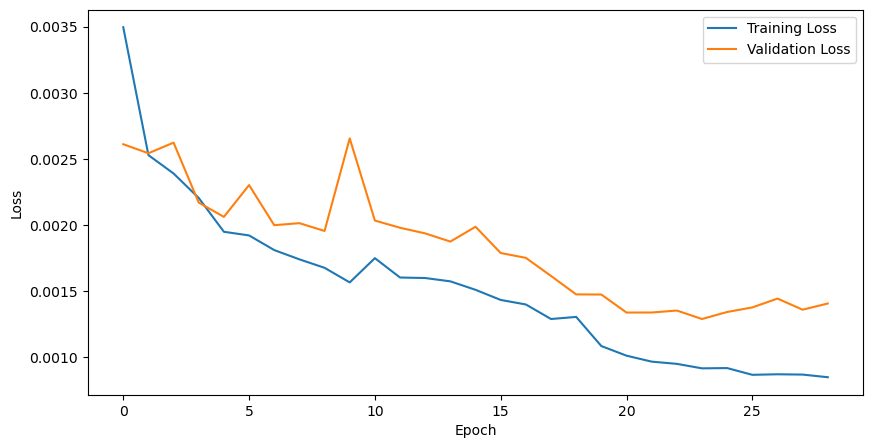

In [ ]:
# %%

plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
#%%

# Load the best model
model.load_state_dict(torch.load('best_model_last.pth', weights_only=True))

<All keys matched successfully>

In [ ]:
#%%

# save losses
np.save('train_losses_last.npy', train_losses)
np.save('val_losses_last.npy', val_losses)

In [ ]:
#%%

# test without all the stft, mulitlabel etc, we only keep the names of the files, value of k 

model.eval()
test_loss = 0
percussion_files_l = []
noise_names_l = []
mix_names_l = []
k_values_l = []
classes_l = []
noise_audio_l = []

output_waveform_l = []
true_percussion_l = []
mixtures_l = []

si_sdr_list = []

test_bar = tqdm(test_loader, desc=f"Testing Loss: {
                test_loss:.8f}", colour='red')
with torch.no_grad():
    for i, batch in enumerate(test_bar):
        # Move data to device
        mixture = batch['mixture_audio'].to(device)
        # mix_stft = batch['mix_stft'].to(device)
        true_percussion = batch['percussion_audio'].to(device)
        noise_combined= batch['noise_audio']
        percussion_files = batch['perc_name']
        noise_names = batch['noise_name']
        mix_names = batch['mix_name']
        k_values = batch['k']
        classes = batch['noise_classes']

        # Forward pass
        # output, class_output = model(torch.abs(mix_stft))
        output_waveform = model(mixture)['waveform']

        # Calculate the loss
        loss = criterion(output_waveform, true_percussion)
        test_loss += loss.item()
        
        # Calculate SI-SDR for each batch
        si_sdr = calculate_si_sdr(true_percussion, output_waveform)
        si_sdr_list.append(si_sdr.item())

        test_bar.set_description(
            f"Testing Loss: {test_loss/(i+1):.8f}, SI-SDR: {torch.mean(torch.tensor(si_sdr_list)):.8f}")

        # concatenate inside the loop
        percussion_files_l.extend(percussion_files)
        noise_names_l.extend(noise_names)
        mix_names_l.extend(mix_names)
        k_values_l.extend(k_values)
        classes_l.extend(classes)
        noise_audio_l.extend(noise_combined)
        output_waveform_l.extend(output_waveform.cpu().numpy())
        true_percussion_l.extend(true_percussion.cpu().numpy())
        mixtures_l.extend(mixture.cpu().numpy())
        si_sdr_list.extend(si_sdr_list)
        
    test_loss /= len(test_loader)
    
    # concatenate final values
    percussion_files_l.extend(percussion_files)
    noise_names_l.extend(noise_names)
    mix_names_l.extend(mix_names)
    k_values_l.extend(k_values)
    classes_l.extend(classes)
    noise_audio_l.extend(noise_combined)
    output_waveform_l.extend(output_waveform.cpu().numpy())
    true_percussion_l.extend(true_percussion.cpu().numpy())
    mixtures_l.extend(mixture.cpu().numpy())
    si_sdr_list.extend(si_sdr_list)
    
    
    print(f"Testing Loss: {test_loss:.8f}")

Testing Loss: 0.00152992, SI-SDR: 12.73644924:  42%|████▏     | 25/60 [00:18<01:39,  2.85s/it]